In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_normal = pd.read_csv('eval_gpt_4o_mini_persian_qwen1.7b.csv')  # Replace with your file
df_masked = pd.read_csv('eval_gpt_4o_mini_persian_masked_qwen1.7b.csv')  # Replace with your file

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')  # Changed from seaborn-v0_8 for compatibility
sns.set_palette("husl")

class DataFrameEvaluator:
    def __init__(self, df_normal, df_masked):
        """
        Initialize with two dataframes: normal and masked explanations
        
        Args:
            df_normal: DataFrame with normal explanations
            df_masked: DataFrame with masked explanations
        """
        self.df_normal = df_normal.copy()
        self.df_masked = df_masked.copy()
        
        # Ensure both dataframes have the same indices for comparison
        self.common_indices = self.df_normal.index.intersection(self.df_masked.index)
        self.df_normal = self.df_normal.loc[self.common_indices]
        self.df_masked = self.df_masked.loc[self.common_indices]
        
        # Convert boolean columns to int for arithmetic operations
        bool_columns = ['is_correct_noexp', 'is_correct_exp']
        for col in bool_columns:
            if col in self.df_normal.columns:
                self.df_normal[col] = self.df_normal[col].astype(int)
            if col in self.df_masked.columns:
                self.df_masked[col] = self.df_masked[col].astype(int)
        
    def basic_statistics(self):
        """Generate basic statistics for both dataframes"""
        print("="*60)
        print("BASIC STATISTICS COMPARISON")
        print("="*60)
        
        stats_dict = {
            'Metric': [],
            'Normal_Explanation': [],
            'Masked_Explanation': [],
            'Difference': []
        }
        
        # Accuracy comparisons
        acc_normal_noexp = self.df_normal['is_correct_noexp'].mean()
        acc_normal_exp = self.df_normal['is_correct_exp'].mean()
        acc_masked_noexp = self.df_masked['is_correct_noexp'].mean()
        acc_masked_exp = self.df_masked['is_correct_exp'].mean()
        
        metrics = [
            ('Accuracy (No Explanation)', acc_normal_noexp, acc_masked_noexp),
            ('Accuracy (With Explanation)', acc_normal_exp, acc_masked_exp),
            ('Mean Probability (No Exp)', self.df_normal['prob_noexp'].mean(), self.df_masked['prob_noexp'].mean()),
            ('Mean Probability (With Exp)', self.df_normal['prob_exp'].mean(), self.df_masked['prob_exp'].mean()),
            ('Mean Perplexity', self.df_normal['ppl_qwen'].mean(), self.df_masked['ppl_qwen'].mean()),
            ('Mean Sufficiency', self.df_normal['sufficiency'].mean(), self.df_masked['sufficiency'].mean())
        ]
        
        for metric, normal_val, masked_val in metrics:
            stats_dict['Metric'].append(metric)
            stats_dict['Normal_Explanation'].append(f"{normal_val:.4f}")
            stats_dict['Masked_Explanation'].append(f"{masked_val:.4f}")
            stats_dict['Difference'].append(f"{normal_val - masked_val:.4f}")
        
        stats_df = pd.DataFrame(stats_dict)
        print(stats_df.to_string(index=False))
        
        return stats_df
    
    def perplexity_analysis(self):
        """Detailed analysis of perplexity differences"""
        print("\n" + "="*60)
        print("PERPLEXITY ANALYSIS")
        print("="*60)
        
        ppl_normal = self.df_normal['ppl_qwen']
        ppl_masked = self.df_masked['ppl_qwen']
        
        print(f"Normal Explanation Perplexity:")
        print(f"  Mean: {ppl_normal.mean():.4f}")
        print(f"  Median: {ppl_normal.median():.4f}")
        print(f"  Std: {ppl_normal.std():.4f}")
        print(f"  Min: {ppl_normal.min():.4f}")
        print(f"  Max: {ppl_normal.max():.4f}")
        
        print(f"\nMasked Explanation Perplexity:")
        print(f"  Mean: {ppl_masked.mean():.4f}")
        print(f"  Median: {ppl_masked.median():.4f}")
        print(f"  Std: {ppl_masked.std():.4f}")
        print(f"  Min: {ppl_masked.min():.4f}")
        print(f"  Max: {ppl_masked.max():.4f}")
        
        # Statistical test
        t_stat, p_value = stats.ttest_rel(ppl_normal, ppl_masked)
        print(f"\nPaired t-test results:")
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
        
        return {
            'normal_stats': ppl_normal.describe(),
            'masked_stats': ppl_masked.describe(),
            't_stat': t_stat,
            'p_value': p_value
        }
    
    def accuracy_improvement_analysis(self):
        """Analyze how explanations improve accuracy"""
        print("\n" + "="*60)
        print("ACCURACY IMPROVEMENT ANALYSIS")
        print("="*60)
        
        # Calculate improvement for both datasets (now safe with int columns)
        normal_improvement = self.df_normal['is_correct_exp'] - self.df_normal['is_correct_noexp']
        masked_improvement = self.df_masked['is_correct_exp'] - self.df_masked['is_correct_noexp']
        
        print("Normal Explanations:")
        print(f"  Improved: {(normal_improvement > 0).sum()} questions")
        print(f"  Degraded: {(normal_improvement < 0).sum()} questions")
        print(f"  No change: {(normal_improvement == 0).sum()} questions")
        print(f"  Net improvement: {normal_improvement.mean():.4f}")
        
        print("\nMasked Explanations:")
        print(f"  Improved: {(masked_improvement > 0).sum()} questions")
        print(f"  Degraded: {(masked_improvement < 0).sum()} questions")
        print(f"  No change: {(masked_improvement == 0).sum()} questions")
        print(f"  Net improvement: {masked_improvement.mean():.4f}")
        
        return normal_improvement, masked_improvement
    
    def create_visualizations(self):
        """Create comprehensive visualizations"""
        fig = plt.figure(figsize=(20, 16))
        
        # 1. Accuracy Comparison
        plt.subplot(3, 4, 1)
        accuracy_data = {
            'No Explanation': [self.df_normal['is_correct_noexp'].mean(), 
                             self.df_masked['is_correct_noexp'].mean()],
            'With Explanation': [self.df_normal['is_correct_exp'].mean(), 
                               self.df_masked['is_correct_exp'].mean()]
        }
        x = np.arange(len(accuracy_data['No Explanation']))
        width = 0.35
        
        plt.bar(x - width/2, accuracy_data['No Explanation'], width, label='No Explanation', alpha=0.8)
        plt.bar(x + width/2, accuracy_data['With Explanation'], width, label='With Explanation', alpha=0.8)
        plt.xlabel('Dataset Type')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Comparison')
        plt.xticks(x, ['Normal', 'Masked'])
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Perplexity Distribution
        plt.subplot(3, 4, 2)
        plt.hist(self.df_normal['ppl_qwen'], bins=30, alpha=0.7, label='Normal', density=True)
        plt.hist(self.df_masked['ppl_qwen'], bins=30, alpha=0.7, label='Masked', density=True)
        plt.xlabel('Perplexity')
        plt.ylabel('Density')
        plt.title('Perplexity Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. Perplexity Box Plot
        plt.subplot(3, 4, 3)
        data_to_plot = [self.df_normal['ppl_qwen'], self.df_masked['ppl_qwen']]
        plt.boxplot(data_to_plot, labels=['Normal', 'Masked'])
        plt.ylabel('Perplexity')
        plt.title('Perplexity Box Plot')
        plt.grid(True, alpha=0.3)
        
        # 4. Sufficiency Comparison
        plt.subplot(3, 4, 4)
        plt.scatter(self.df_normal['sufficiency'], self.df_masked['sufficiency'], alpha=0.6)
        plt.xlabel('Normal Sufficiency')
        plt.ylabel('Masked Sufficiency')
        plt.title('Sufficiency Correlation')
        plt.plot([0, 1], [0, 1], 'r--', alpha=0.8)
        plt.grid(True, alpha=0.3)
        
        # 5. Probability Comparison (No Explanation)
        plt.subplot(3, 4, 5)
        plt.scatter(self.df_normal['prob_noexp'], self.df_masked['prob_noexp'], alpha=0.6)
        plt.xlabel('Normal Prob (No Exp)')
        plt.ylabel('Masked Prob (No Exp)')
        plt.title('Probability Correlation (No Exp)')
        plt.plot([0, 1], [0, 1], 'r--', alpha=0.8)
        plt.grid(True, alpha=0.3)
        
        # 6. Probability Comparison (With Explanation)
        plt.subplot(3, 4, 6)
        plt.scatter(self.df_normal['prob_exp'], self.df_masked['prob_exp'], alpha=0.6)
        plt.xlabel('Normal Prob (With Exp)')
        plt.ylabel('Masked Prob (With Exp)')
        plt.title('Probability Correlation (With Exp)')
        plt.plot([0, 1], [0, 1], 'r--', alpha=0.8)
        plt.grid(True, alpha=0.3)
        
        # 7. Accuracy Improvement - FIXED
        plt.subplot(3, 4, 7)
        # Now safe to subtract since we converted to int
        normal_improvement = self.df_normal['is_correct_exp'] - self.df_normal['is_correct_noexp']
        masked_improvement = self.df_masked['is_correct_exp'] - self.df_masked['is_correct_noexp']
        
        improvement_counts = {
            'Normal': [
                (normal_improvement == -1).sum(),
                (normal_improvement == 0).sum(),
                (normal_improvement == 1).sum()
            ],
            'Masked': [
                (masked_improvement == -1).sum(),
                (masked_improvement == 0).sum(),
                (masked_improvement == 1).sum()
            ]
        }
        
        x = np.arange(3)
        width = 0.35
        plt.bar(x - width/2, improvement_counts['Normal'], width, label='Normal', alpha=0.8)
        plt.bar(x + width/2, improvement_counts['Masked'], width, label='Masked', alpha=0.8)
        plt.xlabel('Accuracy Change')
        plt.ylabel('Count')
        plt.title('Accuracy Change Distribution')
        plt.xticks(x, ['Degraded', 'No Change', 'Improved'])
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 8. Perplexity vs Accuracy
        plt.subplot(3, 4, 8)
        plt.scatter(self.df_normal['ppl_qwen'], self.df_normal['is_correct_exp'], 
                   alpha=0.6, label='Normal')
        plt.scatter(self.df_masked['ppl_qwen'], self.df_masked['is_correct_exp'], 
                   alpha=0.6, label='Masked')
        plt.xlabel('Perplexity')
        plt.ylabel('Accuracy (With Exp)')
        plt.title('Perplexity vs Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 9. Correlation Matrix for Normal
        plt.subplot(3, 4, 9)
        normal_corr = self.df_normal[['prob_noexp', 'prob_exp', 'is_correct_noexp', 
                                    'is_correct_exp', 'sufficiency', 'ppl_qwen']].corr()
        sns.heatmap(normal_corr, annot=True, cmap='coolwarm', center=0, 
                   square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
        plt.title('Normal Explanations Correlation')
        
        # 10. Correlation Matrix for Masked
        plt.subplot(3, 4, 10)
        masked_corr = self.df_masked[['prob_noexp', 'prob_exp', 'is_correct_noexp', 
                                    'is_correct_exp', 'sufficiency', 'ppl_qwen']].corr()
        sns.heatmap(masked_corr, annot=True, cmap='coolwarm', center=0, 
                   square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
        plt.title('Masked Explanations Correlation')
        
        # 11. Probability Difference Analysis
        plt.subplot(3, 4, 11)
        normal_prob_diff = self.df_normal['prob_exp'] - self.df_normal['prob_noexp']
        masked_prob_diff = self.df_masked['prob_exp'] - self.df_masked['prob_noexp']
        
        plt.hist(normal_prob_diff, bins=30, alpha=0.7, label='Normal', density=True)
        plt.hist(masked_prob_diff, bins=30, alpha=0.7, label='Masked', density=True)
        plt.xlabel('Probability Difference (With - Without Exp)')
        plt.ylabel('Density')
        plt.title('Explanation Effect on Probability')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 12. Perplexity Difference
        plt.subplot(3, 4, 12)
        ppl_diff = self.df_normal['ppl_qwen'] - self.df_masked['ppl_qwen']
        plt.hist(ppl_diff, bins=30, alpha=0.7, edgecolor='black')
        plt.xlabel('Perplexity Difference (Normal - Masked)')
        plt.ylabel('Frequency')
        plt.title('Perplexity Difference Distribution')
        plt.axvline(x=0, color='red', linestyle='--', alpha=0.8)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def detailed_comparison_report(self):
        """Generate a detailed comparison report"""
        print("\n" + "="*60)
        print("DETAILED COMPARISON REPORT")
        print("="*60)
        
        # Correlation analysis
        normal_ppl_acc_corr = np.corrcoef(self.df_normal['ppl_qwen'], 
                                         self.df_normal['is_correct_exp'])[0, 1]
        masked_ppl_acc_corr = np.corrcoef(self.df_masked['ppl_qwen'], 
                                         self.df_masked['is_correct_exp'])[0, 1]
        
        print(f"Perplexity-Accuracy Correlation:")
        print(f"  Normal Explanations: {normal_ppl_acc_corr:.4f}")
        print(f"  Masked Explanations: {masked_ppl_acc_corr:.4f}")
        
        # Explanation effectiveness
        normal_exp_effect = (self.df_normal['prob_exp'] - self.df_normal['prob_noexp']).mean()
        masked_exp_effect = (self.df_masked['prob_exp'] - self.df_masked['prob_noexp']).mean()
        
        print(f"\nExplanation Effect on Probability:")
        print(f"  Normal Explanations: {normal_exp_effect:.4f}")
        print(f"  Masked Explanations: {masked_exp_effect:.4f}")
        
        # Questions where masking helps/hurts
        accuracy_diff = self.df_masked['is_correct_exp'] - self.df_normal['is_correct_exp']
        masking_helps = (accuracy_diff > 0).sum()
        masking_hurts = (accuracy_diff < 0).sum()
        no_difference = (accuracy_diff == 0).sum()
        
        print(f"\nMasking Effect on Accuracy:")
        print(f"  Masking helps: {masking_helps} questions")
        print(f"  Masking hurts: {masking_hurts} questions")
        print(f"  No difference: {no_difference} questions")
        
        return {
            'normal_ppl_acc_corr': normal_ppl_acc_corr,
            'masked_ppl_acc_corr': masked_ppl_acc_corr,
            'normal_exp_effect': normal_exp_effect,
            'masked_exp_effect': masked_exp_effect,
            'masking_helps': masking_helps,
            'masking_hurts': masking_hurts
        }

    def save_results(self, output_dir='results'):
        """Save all results to files"""
        import os
        
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Save basic statistics
        stats_df = self.basic_statistics()
        stats_df.to_csv(f'{output_dir}/comparison_statistics.csv', index=False)
        
        # Save perplexity analysis
        ppl_analysis = self.perplexity_analysis()
        
        # Save detailed report
        detailed_report = self.detailed_comparison_report()
        
        # Save improvement analysis
        normal_improvement, masked_improvement = self.accuracy_improvement_analysis()
        
        # Create summary dataframe
        summary_data = {
            'Dataset': ['Normal', 'Masked'],
            'Accuracy_NoExp': [self.df_normal['is_correct_noexp'].mean(), 
                              self.df_masked['is_correct_noexp'].mean()],
            'Accuracy_WithExp': [self.df_normal['is_correct_exp'].mean(), 
                                self.df_masked['is_correct_exp'].mean()],
            'Mean_Perplexity': [self.df_normal['ppl_qwen'].mean(), 
                               self.df_masked['ppl_qwen'].mean()],
            'Mean_Sufficiency': [self.df_normal['sufficiency'].mean(), 
                                self.df_masked['sufficiency'].mean()],
            'Improvement_Rate': [normal_improvement.mean(), masked_improvement.mean()]
        }
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv(f'{output_dir}/summary_comparison.csv', index=False)
        
        print(f"\nResults saved to '{output_dir}' directory:")
        print(f"  - comparison_statistics.csv")
        print(f"  - summary_comparison.csv")
        
        return summary_df

# Usage example with error handling:
def run_complete_analysis(df_normal, df_masked):
    """Run complete analysis with error handling"""
    try:
        evaluator = DataFrameEvaluator(df_normal, df_masked)
        
        print("Running basic statistics...")
        stats_df = evaluator.basic_statistics()
        
        print("\nRunning perplexity analysis...")
        ppl_analysis = evaluator.perplexity_analysis()
        
        print("\nRunning accuracy improvement analysis...")
        normal_improvement, masked_improvement = evaluator.accuracy_improvement_analysis()
        
        print("\nCreating visualizations...")
        fig = evaluator.create_visualizations()
        
        print("\nGenerating detailed report...")
        detailed_report = evaluator.detailed_comparison_report()
        
        print("\nSaving results...")
        summary_df = evaluator.save_results()
        
        return evaluator, summary_df
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        print("Please check your dataframe column names and data types.")
        return None, None

# Now you can run:
# evaluator, summary = run_complete_analysis(df_normal, df_masked)

Running basic statistics...
BASIC STATISTICS COMPARISON
                     Metric Normal_Explanation Masked_Explanation Difference
  Accuracy (No Explanation)             0.4793             0.4793     0.0000
Accuracy (With Explanation)             0.8764             0.8260     0.0504
  Mean Probability (No Exp)             0.7284             0.7284     0.0000
Mean Probability (With Exp)             0.9374             0.9079     0.0295
            Mean Perplexity             4.7427             5.0310    -0.2883
           Mean Sufficiency             0.8710             0.8074     0.0635

Running perplexity analysis...

PERPLEXITY ANALYSIS
Normal Explanation Perplexity:
  Mean: 4.7427
  Median: 4.5664
  Std: 1.2137
  Min: 2.2731
  Max: 14.3706

Masked Explanation Perplexity:
  Mean: 5.0310
  Median: 4.7794
  Std: 1.3626
  Min: 2.3243
  Max: 15.8729

Paired t-test results:
  t-statistic: -25.7202
  p-value: 0.0000
  Significant difference: Yes

Running accuracy improvement analysis...



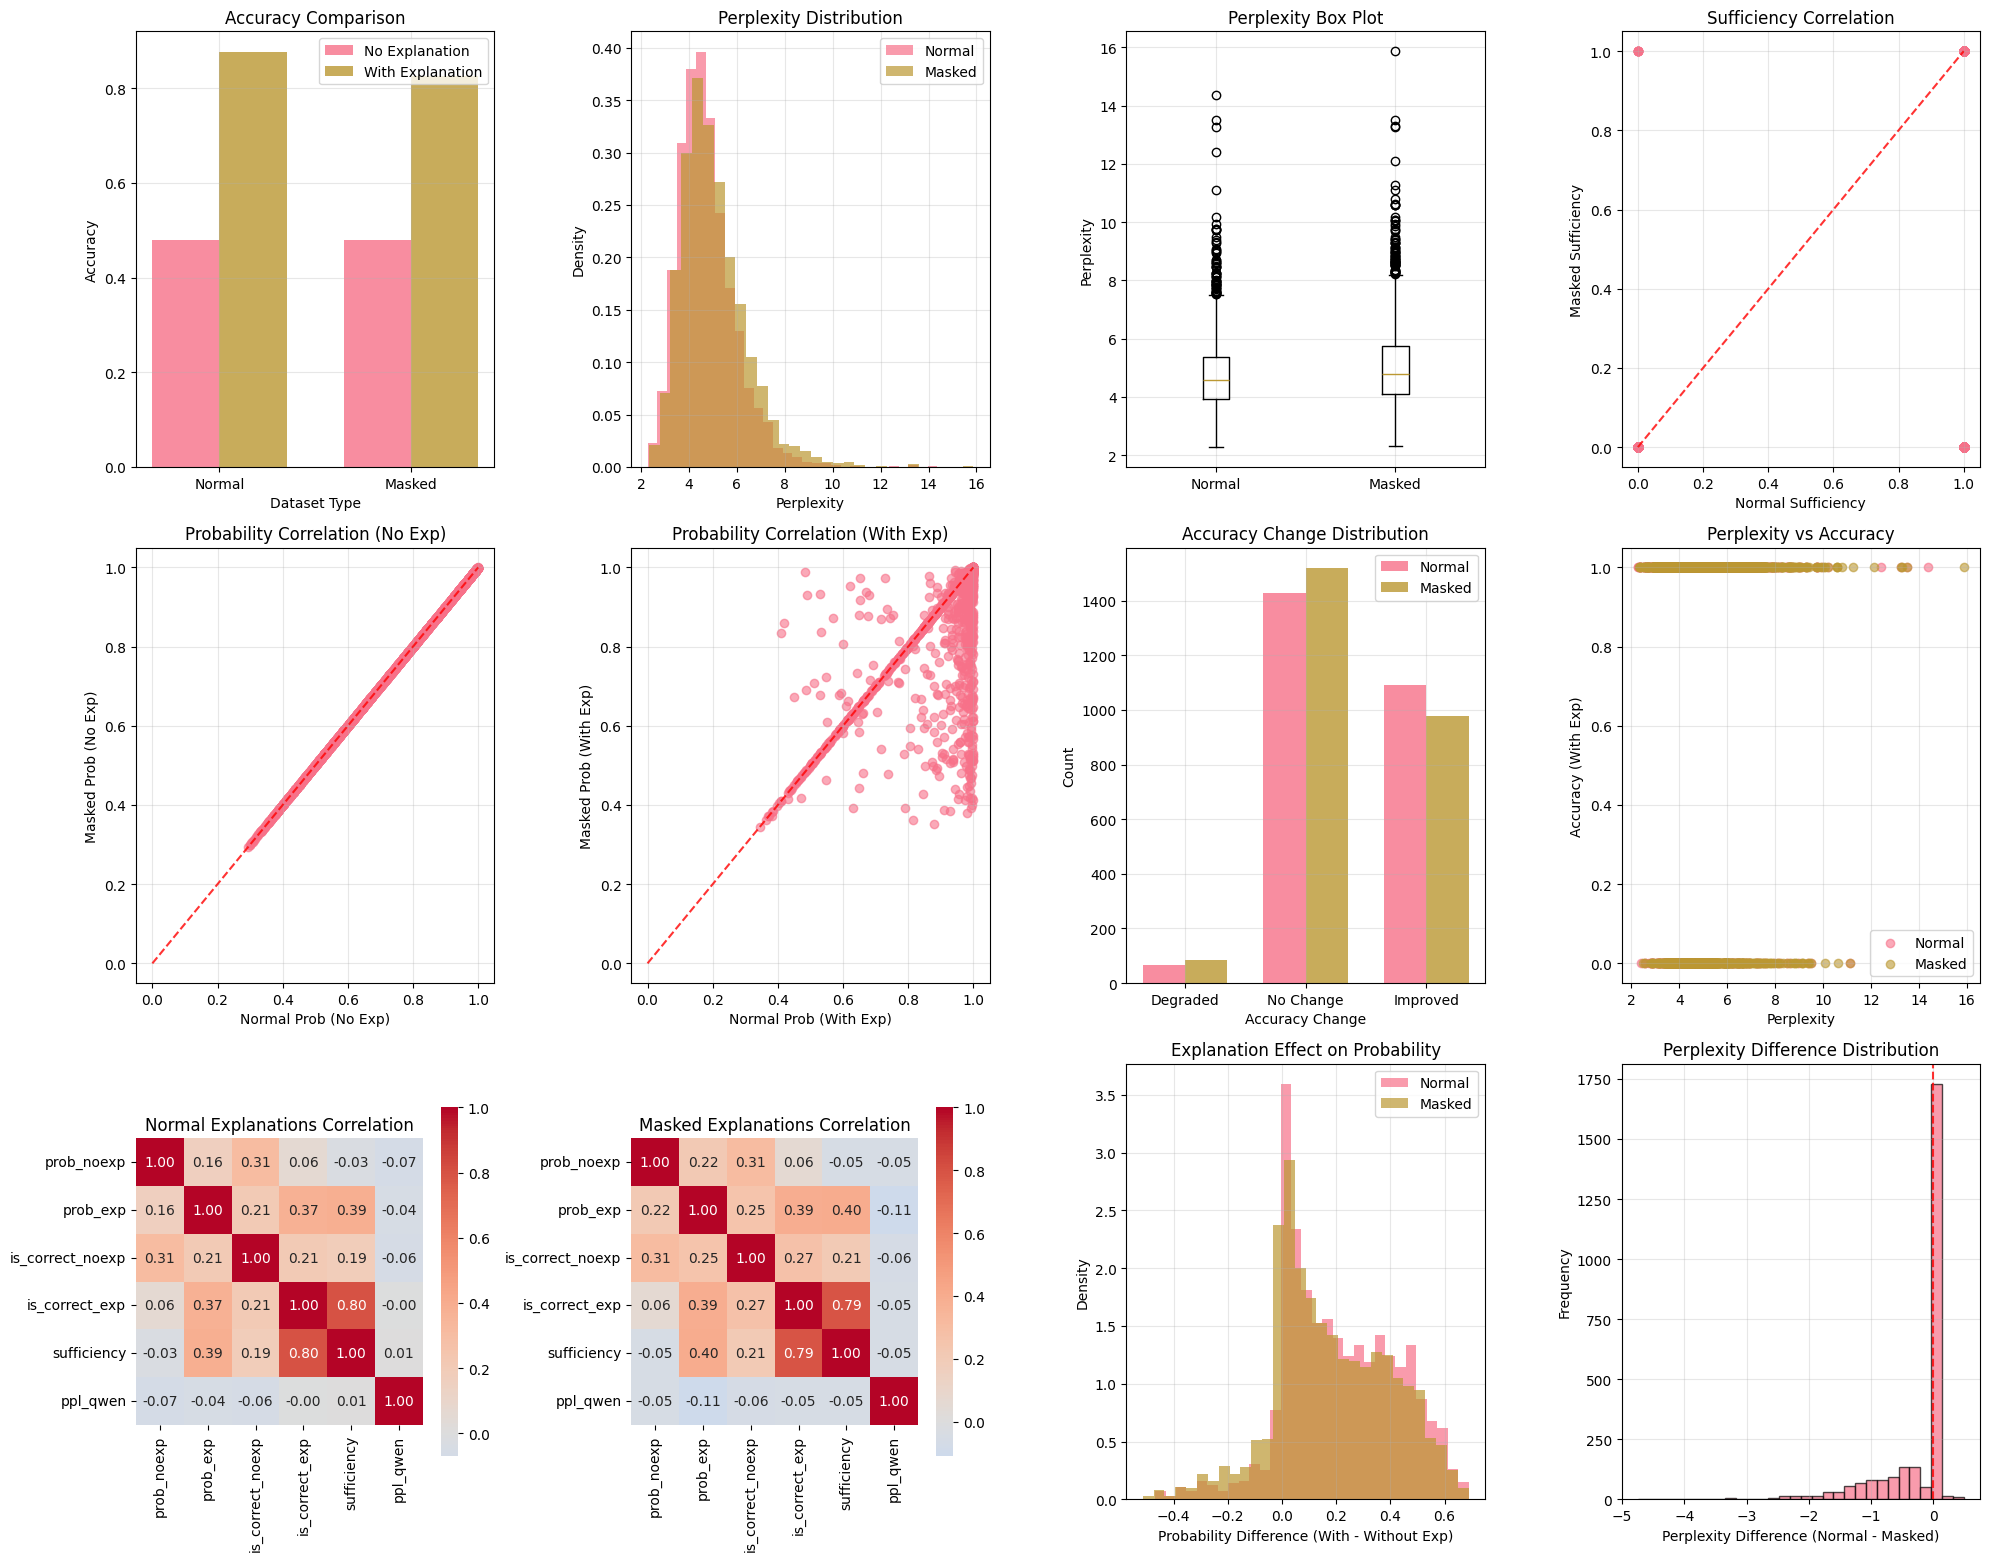


Generating detailed report...

DETAILED COMPARISON REPORT
Perplexity-Accuracy Correlation:
  Normal Explanations: -0.0026
  Masked Explanations: -0.0463

Explanation Effect on Probability:
  Normal Explanations: 0.2090
  Masked Explanations: 0.1795

Masking Effect on Accuracy:
  Masking helps: 8 questions
  Masking hurts: 138 questions
  No difference: 2435 questions

Saving results...
BASIC STATISTICS COMPARISON
                     Metric Normal_Explanation Masked_Explanation Difference
  Accuracy (No Explanation)             0.4793             0.4793     0.0000
Accuracy (With Explanation)             0.8764             0.8260     0.0504
  Mean Probability (No Exp)             0.7284             0.7284     0.0000
Mean Probability (With Exp)             0.9374             0.9079     0.0295
            Mean Perplexity             4.7427             5.0310    -0.2883
           Mean Sufficiency             0.8710             0.8074     0.0635

PERPLEXITY ANALYSIS
Normal Explanation Per

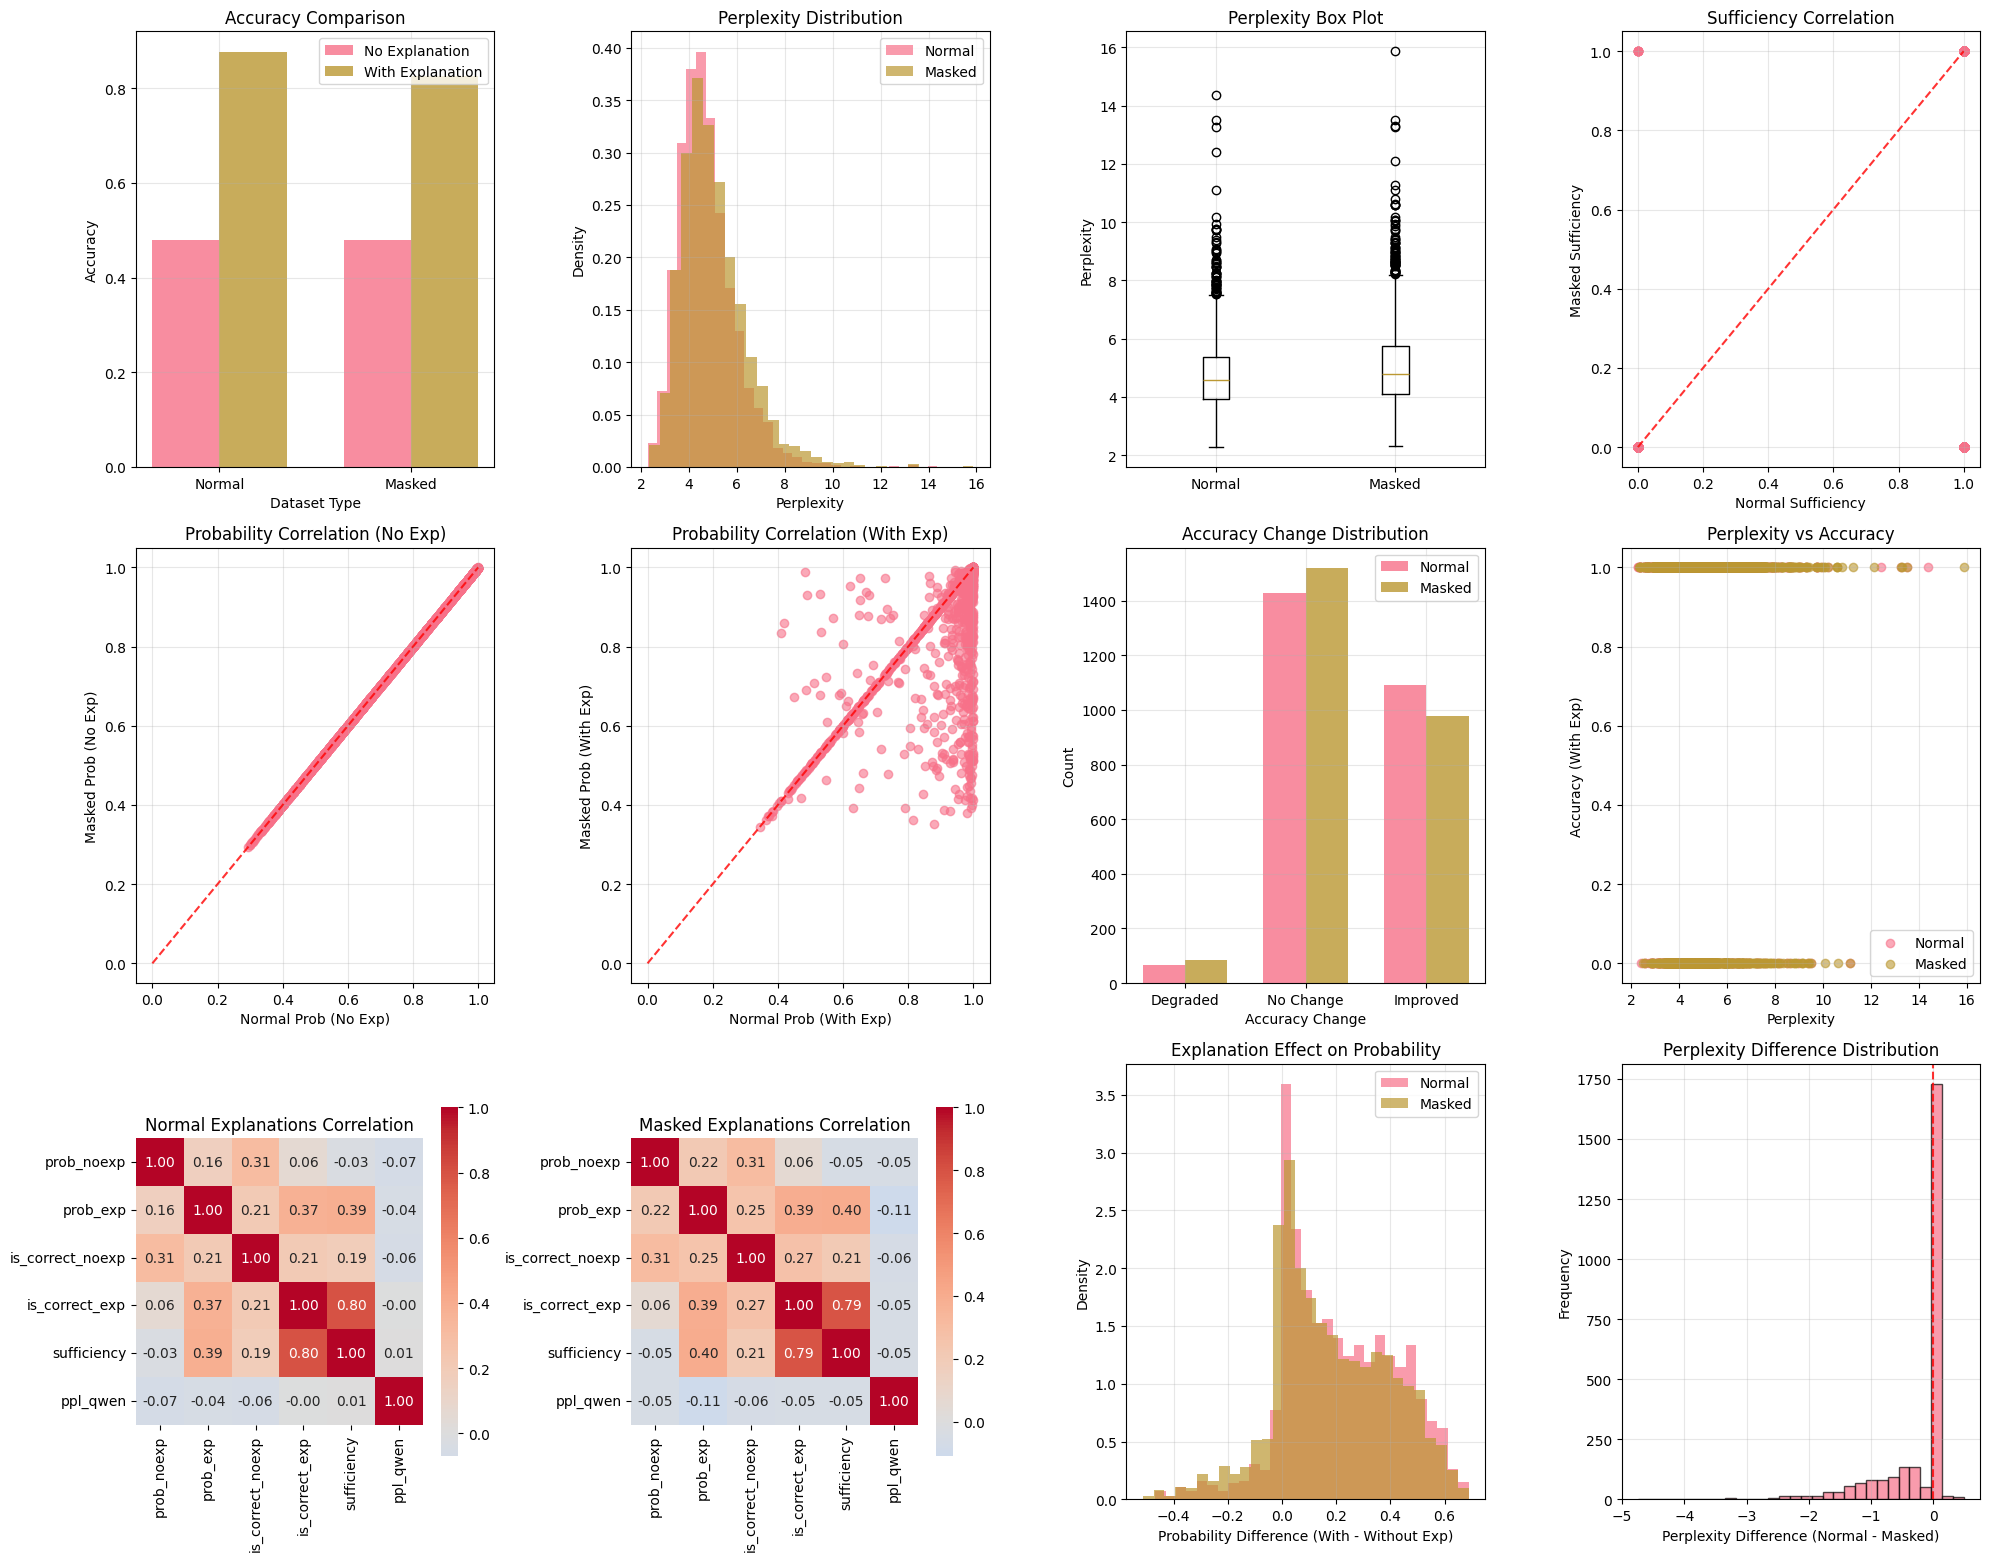


DETAILED COMPARISON REPORT
Perplexity-Accuracy Correlation:
  Normal Explanations: -0.0026
  Masked Explanations: -0.0463

Explanation Effect on Probability:
  Normal Explanations: 0.2090
  Masked Explanations: 0.1795

Masking Effect on Accuracy:
  Masking helps: 8 questions
  Masking hurts: 138 questions
  No difference: 2435 questions


{'normal_ppl_acc_corr': -0.0026353080132445247,
 'masked_ppl_acc_corr': -0.046338062685848225,
 'normal_exp_effect': 0.20898343249145102,
 'masked_exp_effect': 0.17945088973252268,
 'masking_helps': 8,
 'masking_hurts': 138}

In [21]:
# Run the complete analysis
evaluator, summary = run_complete_analysis(df_normal, df_masked)

# Or run individual components:
evaluator = DataFrameEvaluator(df_normal, df_masked)
evaluator.create_visualizations()
evaluator.detailed_comparison_report()